<h1 align="center">S2R Analytics</h1>

# Table of Contents

* [1](#1): Projects
* [2](#2): Transactions
* [3](#3): Staff & teams
* [4](#4): Stages
* [5](#5): Clients 
* [6](#6): Clean-up
* [7](#7): Pre-processing

## Notebook Setup

In [52]:
# Essentials
import pandas as pd
from pandas import Series, DataFrame
from pandas.api.types import CategoricalDtype
pd.options.display.max_columns = None
import numpy as np; np.random.seed(2022)
import random
import sqlite3
import pyodbc
import copy

# Image creation and display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib import pyplot
import plotly.express as px
import plotly.graph_objects as go

# Preprocessing
from sklearn import preprocessing
from numpy import percentile
from numpy.random import seed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Other
import itertools as it
import io
import os
os.sys.path
import sys
import glob
import concurrent.futures
from __future__ import print_function
import binascii
import struct
from PIL import Image
import scipy
import scipy.misc
import scipy.cluster
import datetime, time
import functools, operator
from datetime import datetime

## 1. <a class="anchor" id="1"></a> Projects

Step 1: Create a list of projects to drop.

In [53]:
# Read all projects from Synergy API
all_projects = pd.read_csv('csv-files/wga_synergy_incremental_projects.csv')
all_projects = all_projects[['Project ID', 'Project Number', 'Project Name', 'Is Office Project', 'Is Billable', 'Project Status']]

# Projects to keep: external (i.e. client only)
external_projects = all_projects[(all_projects['Is Office Project'] != 'Yes')]
external_projects = external_projects[(external_projects['Is Billable'] != 'No')]
external_ids = external_projects['Project ID'].tolist()

# Projects to keep: status-based
successful_projects = external_projects[external_projects['Project Status'].isin(['Complete']) == True]
valid_ids = successful_projects['Project ID'].tolist()

# See how many unique projects we shold have
print('We should have ' + str(len(valid_ids)) + ' projects in total.')

We should have 7222 projects in total.


In [54]:
print('Hence, ' + str(len(all_projects) - len(valid_ids)) + ' projects were dropped for being invalid.')

Hence, 8103 projects were dropped for being invalid.


Step 2: Cleaning data from Synergy API.

In [55]:
# Load only valid projects
api_projects = pd.read_csv('csv-files/wga_synergy_incremental_projects.csv', parse_dates=['Start Date (Project)', 'End Date (Project)'], dayfirst=True)
api_projects = (api_projects[api_projects['Project ID'].isin(valid_ids)])


# Drop unnecesary columns
api_projects.drop(columns = ['Unnamed: 0', 'Primary Contact Name', 'Status Name', 'Organisation ID',
                             'customFields', 'Address Line 1', 'Address Line 2', 'Project Type ID',
                             'Primary Contact', 'Primary Contact ID', 'Project Scope', 'Address Postal Code',
                             'Address State', 'Address Town', 'Address Google', 'Client Reference Number',
                             'Address State Postal Code Country', 'Address Single Line', 'Project Type Code',
                             'External Name', 'Address Longitude', 'Address Latitude', 'Project Manager', 
                             'Project Forecast Value', 'Created Date', 'Updated Date'], inplace = True)


# Convert columns for unified style
api_projects.rename(columns = {'Invoices':'Number of Invoices', 'Project Net Residual (Neg as Zero)':'Project Net Residual',
                              'Start Date (Project)': 'Project Start Date', 'End Date (Project)': 'Project End Date',
                              'Address Country':'Country', 'Project Type': 'Sector'}, inplace = True)
api_projects['Country'].replace(['AUSTRALIA', 'AUS', 'Autralia', 'NZ', 'new zealand', 'PNG', 'samoa', 'SAMOA', 'TONGA', 'SA', 'CHINA'],
                                ['Australia', 'Australia', 'Australia', 'New Zealand', 'New Zealand', 'Papua New Guinea', 'Samoa', 'Samoa', 'Tonga', 'Saudi Arabia', 'China'],inplace=True)


# Generalise minority observations into bigger groups
api_projects['Sector'].mask(api_projects['Sector'] == 'Commercial', 'Commercial & Retail Buildings', inplace=True)
api_projects['Sector'].mask(api_projects['Sector'] == 'Residential', 'Civic & Education Buildings', inplace=True)

Charge_Rates = {}

for rates in api_projects['Default Rate Group']:
    if rates == 'Standard':
        Charge_Rates[rates] = 'Standard'
    elif rates.startswith('WA Chargeout') == True:
        Charge_Rates[rates] = 'WA chargeout rates'
    elif rates.startswith('SA') == True:
        Charge_Rates[rates] = 'SA chargeout rates'
    elif rates.startswith('Vic') == True:
        Charge_Rates[rates] = 'Vic chargeout rates'
    elif rates.startswith('NZ') == True:
        Charge_Rates[rates] = 'NZ chargeout rates'
    elif rates.startswith('QLD') == True:
        Charge_Rates[rates] = 'QLD chargeout rates'
    else:
        Charge_Rates[rates] = 'Other'

df_1 = pd.DataFrame([{'Default Rate Group': rates, 'Rate Group': rate_group} for (rates, rate_group) in Charge_Rates.items()])

api_projects = pd.merge(api_projects, df_1, how ='left', on='Default Rate Group')


# Adding 'Due Date' and'Project Director' columns
custom_fields = pd.read_csv('csv-files/wga_synergy_incremental_projects_custom_fields.csv')
custom_fields = custom_fields[['PROPOSAL - Due Date', 'PROSPECT - Project Director', 'Project ID']].copy()
custom_fields.rename(columns = {'PROSPECT - Project Director':'Project Director', 'PROPOSAL - Due Date': 'Due Date'}, inplace = True)
custom_fields['Project Director'] = custom_fields['Project Director'].str.rstrip(' (MPD)')
custom_fields['Due Date'] = pd.to_datetime(custom_fields['Due Date'])
api_projects = pd.merge(api_projects, custom_fields,  how='left', on='Project ID')


# Rearrange column names for easier interpretation
api_projects = api_projects[['Project ID', 'Country',
                             'Project Status', 'Sector',
                             'Project Director', 'Manager ID', 'Office',
                             'Project Start Date', 'Project End Date', 'Due Date', 'Rate Group']]

len(api_projects)

7222

Step 3: Cleaning transformed PowerBI data from S2R Analytics.

In [56]:
# Read the pre-transformed data from PowerBI
pbi_projects = pd.read_csv('csv-files/wga_power_bi_projects.csv', encoding = 'ISO-8859-1', low_memory=False)
pbi_projects = pbi_projects[['Project ID', 'Project Size Sort Order', 'Is Multi Discipline Project','Is First Client Project']]

# Load only valid projects
pbi_projects = (pbi_projects[pbi_projects['Project ID'].isin(valid_ids)])

# Convert columns for unified style
pbi_projects['Is Multi Discipline Project'].replace(['No', 'Yes'],[False, True],inplace=True)
pbi_projects['Is First Client Project'].replace(['No', 'Yes'],[False, True],inplace=True)

# Convert the object column to boolean
pbi_projects['Is Multi Discipline Project'] = pbi_projects['Is Multi Discipline Project'].astype(bool)
pbi_projects['Is Multi Discipline Project'] = pbi_projects['Is Multi Discipline Project'].astype(int)
pbi_projects['Is First Client Project'] = pbi_projects['Is First Client Project'].astype(int)

len(pbi_projects)

7222

Step 4: Merge the two 'Projects' tables together.

In [57]:
# Merge the projects table from API and preprocesed Power BI table
projects = pd.merge(api_projects, pbi_projects,  how='left', left_on='Project ID', right_on='Project ID')
projects.columns = projects.columns.str.replace(' ', '_')
projects.head(1)

,Project_ID,Country,Project_Status,Sector,Project_Director,Manager_ID,Office,Project_Start_Date,Project_End_Date,Due_Date,Rate_Group,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_First_Client_Project
0,367704,Australia,Complete,Ports & Marine,Mark Gilbert,7612852,Whyalla,2015-07-01,2015-08-01,NaT,Standard,4,0,1


## 2. <a class="anchor" id="2"></a> Transactions

### 2.1 <a class="anchor" id="2.1"></a> Data cleaning

In [58]:
# Read only valid projects' transactions from Synergy API.
transactions = pd.read_csv('csv-files/wga_sql_transactions.csv', parse_dates=['date'], dayfirst=True, low_memory=False)
transactions = (transactions[transactions['projectId'].isin(valid_ids)])

transactions = transactions[['id', 'projectId', 'stageId', 'staffId', 'transactionTypeId',
                             'rateType', 'status','units',
                             'invoiceValueTotal','actualCostTotal', 'date']]

transactions.rename(columns = {'id':'Transaction ID', 'projectId':'Project ID',
                                'staffId':'Staff ID',
                               'transactionTypeId': 'Transaction Type',
                               'rateType': 'Rate Type', 'status': 'Status',
                               'stageId': 'Stage ID', 'date':'Date',
                               'invoiceValueTotal': 'Invoice Value Total',
                               'actualCostTotal':'Actual Cost Total',
                               'units': 'Units'}, inplace = True)

transactions = transactions[(transactions['Status'] == 'Invoiced') | (transactions['Status'] == 'Written off')]
transactions['Transaction Type'].replace([100, 200, 300, 400, 500, 700, 750, 800],
                                         ['Time', 'Cash', 'Travel', 'Office', 'Bill', 'Balance', 'Unearned', 'Invoice Custom'], inplace=True)
transactions['Date'] = pd.to_datetime(transactions['Date'])
transactions.columns = transactions.columns.str.replace(' ', '_')
transactions = transactions[['Project_ID', 'Staff_ID', 'Transaction_Type', 'Invoice_Value_Total', 'Actual_Cost_Total',  'Units', 'Rate_Type', 'Date']]
transactions = transactions[(transactions['Transaction_Type'] == 'Time') | (transactions['Transaction_Type'] == 'Bill')]

recorded_invoice = transactions.loc[transactions['Invoice_Value_Total'] != 0.0]
recorded_invoice_ids = recorded_invoice['Project_ID'].tolist()
transactions = (transactions[transactions['Project_ID'].isin(recorded_invoice_ids)])

print('Only ' + str(transactions['Project_ID'].nunique()) + ' projects have transaction recorded, meaning ' + str(len(projects) - transactions['Project_ID'].nunique()) + ' projects will be missing from transaction table.')
transactions.reset_index(inplace=True, drop=True)
transactions

Only 6265 projects have transaction recorded, meaning 957 projects will be missing from transaction table.


,Project_ID,Staff_ID,Transaction_Type,Invoice_Value_Total,Actual_Cost_Total,Units,Rate_Type,Date
0,768524,8553176.0,Time,0.00,203.975,2.5,Staff,2021-06-02
1,768524,8553176.0,Time,0.00,81.590,1.0,Staff,2021-06-03
2,768524,8553176.0,Time,0.00,40.795,0.5,Staff,2021-06-04
3,768524,7612693.0,Time,0.00,771.540,6.0,Staff,2021-06-02
4,768524,7612942.0,Time,0.00,284.625,2.5,Staff,2021-07-01
...,...,...,...,...,...,...,...,...
527404,1116173,7613114.0,Time,256.12,211.140,2.0,Staff,2022-03-16
527405,1116173,7613159.0,Time,351.25,306.360,4.0,Staff,2022-03-17
527406,1116173,7613159.0,Time,526.87,459.540,6.0,Staff,2022-03-18
527407,1116173,7613114.0,Time,64.03,52.785,0.5,Staff,2022-03-17


### 2.2 <a class="anchor" id="2.2"></a> Creating and investigating profit margins

In [59]:
# Profit_Margin
df_8 = pd.DataFrame(transactions.groupby(['Project_ID'])[['Invoice_Value_Total', 'Actual_Cost_Total']].sum()).reset_index()
df_8['Profit_Margin'] = (df_8['Invoice_Value_Total'] - df_8['Actual_Cost_Total'])/ df_8['Invoice_Value_Total']
df_8['Profit_Margin'] = df_8['Profit_Margin'].astype('float')
print('Profit margins vary between ' + str(df_8['Profit_Margin'].min()) + ' and ' + str(df_8['Profit_Margin'].max()) + '.')

Profit margins vary between -65.60884374999999 and 1.0.


In [60]:
lowest = df_8.loc[df_8['Profit_Margin'] == df_8['Profit_Margin'].min()]
lowest

,Project_ID,Invoice_Value_Total,Actual_Cost_Total,Profit_Margin
1504,370007,4400.0,293078.9125,-65.608844


In [61]:
positives = df_8.loc[df_8['Profit_Margin'] > 0]
print('There are ' + str(len(positives)) + ' projects with profit margin higher than 0.')
negatives = df_8.loc[df_8['Profit_Margin'] < 0]
print('There are ' + str(len(negatives)) + ' projects with profit margin lower than 0.')
zeros = df_8.loc[df_8['Profit_Margin'] == 0]
print('There are ' + str(len(zeros)) + ' projects with profit margin equal to 0.')

There are 5443 projects with profit margin higher than 0.
There are 817 projects with profit margin lower than 0.
There are 5 projects with profit margin equal to 0.


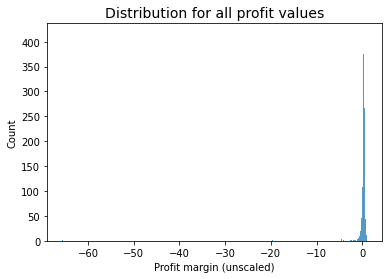

In [62]:
# No scaling with outliers
ax = plt.gca()
sns.histplot(df_8['Profit_Margin'], linewidth=0)
plt.xlabel('Profit margin (unscaled)')
plt.title('Distribution for all profit values', size=14)
plt.show()

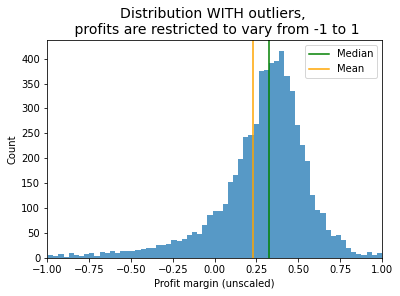

In [63]:
# No scaling, with outliers
ax = plt.gca()
ax.set_xlim([-1.0, 1.0])
sns.histplot(df_8['Profit_Margin'], linewidth=0)
plt.xlabel('Profit margin (unscaled)')

profit = df_8['Profit_Margin']
median=profit.median()
plt.axvline(median, color='green', linestyle='-', label='Median')
mean=profit.mean()
ax.axvline(mean, color='orange', linestyle='-', label='Mean')
ax.legend()
ax.grid(False)
plt.title('Distribution WITH outliers, \n profits are restricted to vary from -1 to 1', size=14)
plt.show()

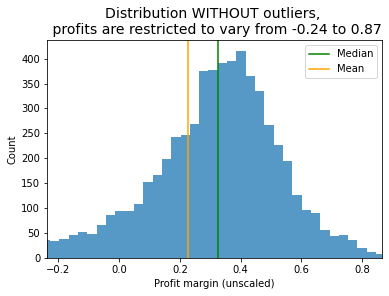

In [64]:
# No scaling, no outliers
ax = plt.gca()
ax.set_xlim([-0.23686749999999998, 0.8659844999999999])
sns.histplot(df_8['Profit_Margin'], linewidth=0)
plt.xlabel('Profit margin (unscaled)')

profit = df_8['Profit_Margin']
median=profit.median()
plt.axvline(median, color='green', linestyle='-', label='Median')
mean=profit.mean()
ax.axvline(mean, color='orange', linestyle='-', label='Mean')
ax.legend()
ax.grid(False)
plt.title('Distribution WITHOUT outliers, \n profits are restricted to vary from -0.24 to 0.87', size=14)
plt.show()

In [65]:
df_8['Profit_Margin'].quantile([0.25, 0.75], interpolation='nearest')

0.25    0.166902
0.75    0.449724
Name: Profit_Margin, dtype: float64

In [66]:
# Calculate the minimum and maximum bounds aside outliers
q1 = 0.166902
q3 = 0.449724
minimum = q1 - 1.5*(q3-q1)
maximum = q3 + 1.5*(q3-q1)

print('Minimum is ', str(minimum), '\nMaximum is ', str(maximum), '\nMedium is ', str(df_8['Profit_Margin'].median()))

Minimum is  -0.25733100000000003 
Maximum is  0.8739570000000001 
Medium is  0.32698281249999994


In [67]:
seed(1)
q25, q75 = percentile(df_8['Profit_Margin'], 25), percentile(df_8['Profit_Margin'], 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
all_outliers = [x for x in df_8['Profit_Margin'] if x < lower or x > upper]
print('All outliers: %d' % len(all_outliers))
lower_outliers = [x for x in df_8['Profit_Margin'] if x < lower]
print('Lower outliers: %d' % len(lower_outliers))
outliers_removed = [x for x in df_8['Profit_Margin'] if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

Percentiles: 25th=0.167, 75th=0.450, IQR=0.283
All outliers: 414
Lower outliers: 382
Non-outlier observations: 5851


In [68]:
lower_outliers = [x for x in df_8['Profit_Margin'] if x < lower]
print('Lower outliers: %d' % len(lower_outliers))

Lower outliers: 382


In [69]:
redefined_lower_outliers = [x for x in df_8['Profit_Margin'] if x < -0.8739570000000001]
print('Redefined lower outliers: %d' % len(redefined_lower_outliers))

Redefined lower outliers: 111


In [70]:
df_8 = df_8[(df_8['Profit_Margin'] >= -0.25733100000000003) & (df_8['Profit_Margin'] <= 0.8739570000000001)]
df_8

,Project_ID,Invoice_Value_Total,Actual_Cost_Total,Profit_Margin
0,367704,46395.0,42861.8975,0.076153
1,367705,612.5,228.9100,0.626269
2,367706,880.0,454.4400,0.483591
3,367707,18420.0,18312.6300,0.005829
4,367708,275817.5,309906.4175,-0.123592
...,...,...,...,...
6260,1420741,5410.0,3356.4025,0.379593
6261,1420788,3940.0,2791.5400,0.291487
6262,1421714,3584.5,1797.7950,0.498453
6263,1458083,3350.0,2273.5200,0.321337


In [71]:
#df_8 = df_8[(df_8['Profit_Margin'] >= -0.873957000000000) & (df_8['Profit_Margin'] <= 0.873957000000000)]
#df_8

In [72]:
print('Profit margins vary between ' + str(df_8['Profit_Margin'].min()) + ' and ' + str(df_8['Profit_Margin'].max()) + '.')

Profit margins vary between -0.25725496183206115 and 0.8736523131672598.


In [73]:
# Add the 'Profit_Margin' to the 'Projects' table
projects = pd.merge(df_8, projects, how='left', on='Project_ID')
projects.drop(['Invoice_Value_Total', 'Actual_Cost_Total'], axis=1, inplace = True)

In [74]:
profit_class = {}
for pr in df_8['Profit_Margin']:
  if pr < 0:
    profit_class[pr] = 0  # negative profitability
  elif pr > 0.3:
    profit_class[pr] = 2 # good profitability
  else:
    profit_class[pr] = 1 # low profitability

In [75]:
pr_class_df = pd.DataFrame([{'Profit_Margin': pr, 'Profit_Class': profit_class} for (pr, profit_class) in profit_class.items()])
pr_class_df

,Profit_Margin,Profit_Class
0,0.076153,1
1,0.626269,2
2,0.483591,2
3,0.005829,1
4,-0.123592,0
...,...,...
5735,0.379593,2
5736,0.291487,1
5737,0.498453,2
5738,0.321337,2


In [76]:
df_9 = pd.merge(projects, pr_class_df,  how='left', on='Profit_Margin')

In [77]:
df_9['Profit_Class'].value_counts()

2    3418
1    1998
0     435
Name: Profit_Class, dtype: int64

In [78]:
profit_bins = pd.DataFrame({'categories': ['negative', 'low', 'good'],
                              'project_count': [435, 1998, 3418]})

Text(0.5, 0, 'Profitability category')

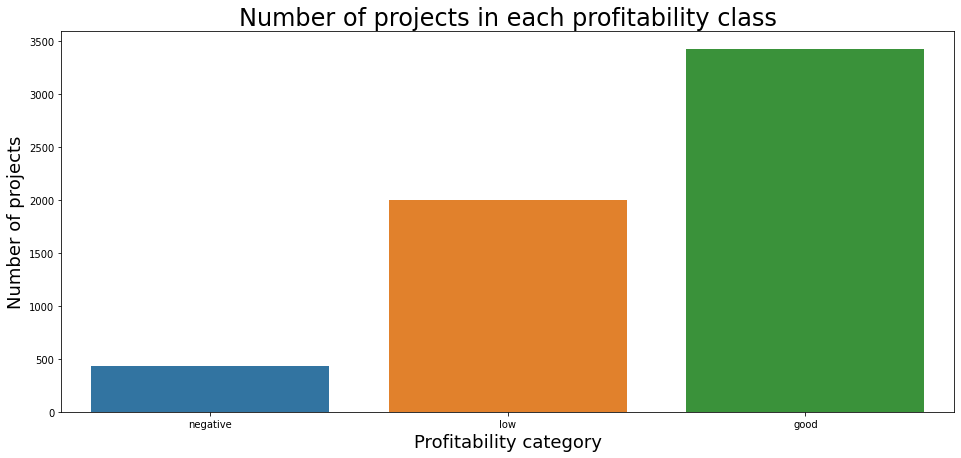

In [79]:
plt.figure(figsize=(16,7))
ax = sns.barplot(x = 'categories', y = 'project_count', data = profit_bins)
plt.title('Number of projects in each profitability class', fontsize=24)
plt.ylabel('Number of projects', fontsize=18)
plt.xlabel('Profitability category', fontsize=18)

In [80]:
df_9 = df_9[['Project_ID', 'Profit_Class']]
projects = pd.merge(projects, df_9, how='left', on='Project_ID')
projects

,Project_ID,Profit_Margin,Country,Project_Status,Sector,Project_Director,Manager_ID,Office,Project_Start_Date,Project_End_Date,Due_Date,Rate_Group,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_First_Client_Project,Profit_Class
0,367704,0.076153,Australia,Complete,Ports & Marine,Mark Gilbert,7612852,Whyalla,2015-07-01,2015-08-01,NaT,Standard,4,0,1,1
1,367705,0.626269,Australia,Complete,Civic & Education Buildings,Geoff Wallbridge,7612773,WGASA Pty Ltd,NaT,NaT,NaT,Standard,1,0,1,2
2,367706,0.483591,Australia,Complete,Civic & Education Buildings,Loreto Taglienti,7612773,WGASA Pty Ltd,NaT,NaT,NaT,Standard,1,0,1,2
3,367707,0.005829,Australia,Complete,Commercial & Retail Buildings,Mark Gilbert,7612773,WGASA Pty Ltd,NaT,NaT,NaT,Standard,3,0,1,1
4,367708,-0.123592,Australia,Complete,Civic & Education Buildings,Peter McBean,7612695,WGASA Pty Ltd,NaT,NaT,NaT,Standard,7,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5846,1420741,0.379593,Australia,Complete,Resources,Russell Perry,7612939,WGASA Pty Ltd,2022-02-22,2022-03-07,2022-02-24,SA chargeout rates,2,0,0,2
5847,1420788,0.291487,Australia,Complete,Health & Aged Care,Mark Gobolos,9683807,WGAVIC Pty Ltd,2022-02-23,2022-02-23,2022-02-25,Vic chargeout rates,1,0,0,1
5848,1421714,0.498453,Australia,Complete,Ports & Marine,David McKay,7613114,WGASA Pty Ltd,2022-02-24,2022-02-24,NaT,SA chargeout rates,1,0,0,2
5849,1458083,0.321337,Australia,Complete,Health & Aged Care,Mark Gobolos,7612775,WGASA Pty Ltd,2022-03-21,2022-03-21,NaT,SA chargeout rates,1,0,0,2


### 2.3 <a class="anchor" id="2.3"></a> Creating other transaction-based features

Perc_of_Subcontractors = 
* total units of subcontractors divided by
* sum of units where transaction type is 'bill' or 'time'

* 'Time' = Company's employees
* 'Bill' = Hired subcontrators
* Time + Bill = total human capital on project in hours

In [81]:
# Perc_of_Subcontractors
subs = transactions[['Project_ID', 'Units', 'Rate_Type', 'Transaction_Type']]
subs = subs[(subs['Rate_Type'] == 'Subcontractor')]
subs.drop(columns = ['Rate_Type'], inplace = True)
subs = pd.DataFrame(subs.groupby(['Project_ID'])['Units'].sum()).reset_index()
subs.rename(columns = {'Units': 'Sub_Hours_Per_Project'}, inplace = True)

total_hours = transactions[['Project_ID', 'Units', 'Transaction_Type']]
total_hours = total_hours[(total_hours['Transaction_Type'] == 'Time') | (total_hours['Transaction_Type'] == 'Bill')]
total_hours = pd.DataFrame(total_hours.groupby(['Project_ID'])['Units'].sum()).reset_index()
total_hours.rename(columns = {'Units': 'Total_Hours_Per_Project'}, inplace = True)

df_1 = pd.merge(projects, subs, how='left', on='Project_ID')
df_1['Sub_Hours_Per_Project'].fillna(0, inplace=True)
df_2 = pd.merge(df_1, total_hours, how='left', on='Project_ID')
df_2['Total_Hours_Per_Project'].fillna(0, inplace=True)
df_2['Sub_Hours_Per_Project'].isnull().sum(), df_2['Total_Hours_Per_Project'].isnull().sum()
df_2['Perc_of_Subcontractors'] = (df_2['Sub_Hours_Per_Project']/df_2['Total_Hours_Per_Project']).round(decimals = 2)*100
df_2 = df_2[['Project_ID', 'Perc_of_Subcontractors']]

# Add the new feature to the 'Projects' table
projects = pd.merge(projects, df_2,  how='left', on='Project_ID')
len(projects)

5851

In [82]:
# Is_Front_Loaded
project_dates = projects[['Project_ID', 'Project_Start_Date', 'Project_End_Date']]
df_3 = transactions[['Project_ID', 'Units', 'Date']]
df_3 = pd.merge(df_3, project_dates, how='left', left_on='Project_ID', right_on='Project_ID')

first_half = df_3[(df_3['Date']  < df_3['Project_Start_Date'] + (df_3['Project_End_Date'] - df_3['Project_Start_Date'])/2)] # finding mid-point between 2 dates
first_half = pd.DataFrame(first_half.groupby(['Project_ID'])['Units'].sum()).reset_index()
first_half.rename(columns = {'Units': '1st_Half_Units'}, inplace = True)

total_units = pd.DataFrame(df_3.groupby(['Project_ID'])['Units'].sum()).reset_index()
total_units.rename(columns = {'Units': 'Total_Effort_Units'}, inplace = True)

df_4 = pd.merge(total_units, first_half, how ='left', left_on='Project_ID', right_on='Project_ID')
df_4['Perc_Being_Front'] = df_4['1st_Half_Units']/df_4['Total_Effort_Units']
df_4['Is_Front_Loaded'] = (df_4['Perc_Being_Front']>=0.7)
df_4 = df_4[['Project_ID', 'Is_Front_Loaded']]

# Add the new feature to the 'Projects' table
projects = pd.merge(projects, df_4,  how='left', left_on='Project_ID', right_on='Project_ID')
len(projects)

5851

In [83]:
# Project_Start_Date, Project_End_Date

def nat_check(date):
    if type(date) == pd._libs.tslibs.nattype.NaTType:
        return True
    else:
        return False

min_dates =  pd.DataFrame(transactions.groupby(['Project_ID'])['Date'].min()).reset_index()
min_dates.rename(columns = {'Date':'Min_Date'}, inplace = True)
max_dates =  pd.DataFrame(transactions.groupby(['Project_ID'])['Date'].max()).reset_index()
max_dates.rename(columns = {'Date':'Max_Date'}, inplace = True)
all_dates = pd.merge(min_dates, max_dates, how='left', on='Project_ID')
projects = pd.merge(projects, all_dates, how='left', on='Project_ID')
len(projects)

5851

In [84]:
projects['Project_Start_Date'] = projects['Project_Start_Date'].map(str)
projects['Project_End_Date'] = projects['Project_End_Date'].map(str)
projects['Due_Date'] = projects['Due_Date'].map(str)

projects.loc[projects['Project_Start_Date']=='NaT','Project_Start_Date']=projects['Min_Date']
projects.loc[projects['Project_End_Date']=='NaT','Project_End_Date']=projects['Max_Date']
projects.loc[projects['Due_Date']=='NaT','Due_Date']=projects['Max_Date']

projects['Project_Start_Date'] = pd.to_datetime(projects['Project_Start_Date'])
projects['Project_End_Date'] = pd.to_datetime(projects['Project_End_Date'])
projects['Due_Date'] = pd.to_datetime(projects['Due_Date'])

projects.drop(columns = ['Min_Date', 'Max_Date'], inplace = True)
len(projects)

5851

Now, let's go back to engieering date-dependent features with newly filled in values in the 'Projects' table.

In [85]:
# Project_Duration_Weeks
projects['Project_Duration_Weeks'] = (projects['Project_End_Date'] - projects['Project_Start_Date']).astype('timedelta64[W]')
neg_weeks = projects[(projects['Project_Duration_Weeks'] < 0)]
neg_ids = neg_weeks['Project_ID'].tolist()
neg_weeks = (projects[projects['Project_ID'].isin(neg_ids)])
neg_weeks

,Project_ID,Profit_Margin,Country,Project_Status,Sector,Project_Director,Manager_ID,Office,Project_Start_Date,Project_End_Date,Due_Date,Rate_Group,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_First_Client_Project,Profit_Class,Perc_of_Subcontractors,Is_Front_Loaded,Project_Duration_Weeks
4219,376189,0.557152,Australia,Complete,Health & Aged Care,Cameron Jackson,7612841,WGAVIC Pty Ltd,2019-09-23,1970-01-01,2019-09-24,Standard,1,0,0,2,0.0,False,-2595.0


In [86]:
# Manually substitute those dates that don't make sense from transactions to created and updates dates from the opriginal API table.
projects.loc[projects['Project_ID'] == 376189, 'Project_Start_Date'] = pd.to_datetime('13/08/2019')
projects.loc[projects['Project_ID'] == 376189, 'Project_End_Date'] = pd.to_datetime('25/02/2020')

projects.loc[projects['Project_ID'] == 1311624, 'Project_Start_Date'] = pd.to_datetime('07/12/2021')
projects.loc[projects['Project_ID'] == 1311624, 'Project_End_Date'] = pd.to_datetime('24/01/2022')

In [87]:
projects['Project_Duration_Weeks'] = (projects['Project_End_Date'] - projects['Project_Start_Date']).astype('timedelta64[W]')
neg_weeks = projects[(projects['Project_Duration_Weeks'] < 0)]
neg_ids = neg_weeks['Project_ID'].tolist()
neg_weeks = (projects[projects['Project_ID'].isin(neg_ids)])
neg_weeks

,Project_ID,Profit_Margin,Country,Project_Status,Sector,Project_Director,Manager_ID,Office,Project_Start_Date,Project_End_Date,Due_Date,Rate_Group,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_First_Client_Project,Profit_Class,Perc_of_Subcontractors,Is_Front_Loaded,Project_Duration_Weeks


In [88]:
# Delivered_on_Time
    
Delivered_on_Time = {}

for due_date in projects['Due_Date']:
    for completed in projects['Project_End_Date']:
        if nat_check(due_date) == True:
            continue
        else:
            if due_date <= completed:
                Delivered_on_Time[due_date] = True
            else:
                Delivered_on_Time[due_date] = False

df_7 = pd.DataFrame([{'Due_Date': due_date, 'Delivered_on_Time': is_on_time} for (due_date, is_on_time) in Delivered_on_Time.items()])

projects = pd.merge(projects, df_7, how='left', on='Due_Date')

## 3. <a class="anchor" id="3"></a> Staff & teams

This section resulted in *aec.staff* table in RDS for Client X.

In [89]:
active = pd.read_csv('csv-files/wga_synergy_overnight_1_staff.csv', parse_dates=['Employment Date'], dayfirst=True)
active = active[['Staff ID', 'Staff Name', 'Employment Date', 'Synergy Team']]
active['Employment Date'] = pd.to_datetime(active['Employment Date'])
active['Employment Months'] = ((datetime.now() - active['Employment Date']).astype('timedelta64[M]'))
active.columns = active.columns.str.replace(' ', '_')

leavers = pd.read_csv('csv-files/wga_synergy_overnight_1_staff_-_leavers.csv', parse_dates=['Employment Date', 'Termination Date'], dayfirst=True)
leavers = leavers[['Staff ID', 'Staff Name', 'Employment Date', 'Termination Date', 'Synergy Team']]
leavers['Employment Date'] = pd.to_datetime(leavers['Employment Date'])
leavers['Termination Date'] = pd.to_datetime(leavers['Termination Date'])
leavers['Employment Months'] = ((leavers['Termination Date'] - leavers['Employment Date']).astype('timedelta64[M]'))
leavers.columns = leavers.columns.str.replace(' ', '_')

staff = pd.concat([active, leavers], axis = 0, ignore_index = True) # axis=0 specifies vertical stacking
staff = staff[['Staff_ID', 'Staff_Name', 'Synergy_Team', 'Employment_Months', 'Employment_Date', 'Termination_Date']]
staff

,Staff_ID,Staff_Name,Synergy_Team,Employment_Months,Employment_Date,Termination_Date
0,7612683,Mel Chittleborough,SA - Finance,264.0,2000-09-25,NaT
1,7612686,Andrew Woods,SA - Buildings,437.0,1986-04-25,NaT
2,7612687,Adam Fairhead,SA - Buildings,201.0,2006-01-08,NaT
3,7612688,Alex Granegger Carneiro,SA - Buildings,252.0,2001-09-17,NaT
4,7612691,Alex Lloyd,SA - Civil,179.0,2007-11-12,NaT
...,...,...,...,...,...,...
820,10019349,Tori Davidson,SA - Industrial,1.0,2022-02-01,2022-03-18
821,10053476,Delete Delete,WA - Structural,0.0,2022-01-01,2022-01-01
822,10069064,Rianna Radocchia,WA - Project Delivery Services,1.0,2022-03-14,2022-05-06
823,10077594,Michael Salib,WA - Project Delivery Services,0.0,2022-04-26,2022-04-26


**8 features to engineer and move them all to 'Projects' table:**
* Director_Empl_Months 
* Manager_Empl_Months
* Manager_Is_Recent
* Director_Is_Recent
<br>
<br>
* Team_Size
* Perc_Team_Recent
* Is_Multi_Team
* Num_Teams_Involved

In [90]:
# Director_Is_Recent, Director_Empl_Months

directors = projects[['Project_ID', 'Project_Director', 'Project_Start_Date']]
directors = pd.merge(directors, staff, how='left', left_on='Project_Director', right_on='Staff_Name')
directors.rename(columns = {'Synergy_Team':'Director_Team', 'Employment_Months':'Director_Empl_Months'}, inplace = True)
directors['Months_Before_Project'] = (directors['Project_Start_Date'] - directors['Employment_Date']).astype('timedelta64[M]')
directors.drop(columns = ['Staff_Name', 'Project_Start_Date'], inplace = True)

Director_Is_Recent = {}

for months in directors['Months_Before_Project']:
    if np.isnan(months) == True:
        continue
    else:
        if months < 6:
            Director_Is_Recent[months] = True
        else:
            Director_Is_Recent[months] = False
        
df_13 = pd.DataFrame([{'Months_Before_Project': months, 'Director_Is_Recent': recent_status} for (months, recent_status) in Director_Is_Recent.items()])

directors = pd.merge(directors, df_13, how ='left', on='Months_Before_Project')
directors.drop(columns = ['Employment_Date', 'Termination_Date', 'Months_Before_Project'], inplace = True)
projects = pd.merge(projects, directors, how ='left', on=['Project_ID', 'Project_Director'])
projects.rename(columns = {'Staff_ID':'Director_ID'}, inplace = True)
projects.drop(columns = 'Project_Director', inplace = True)
len(projects)

5851

In [91]:
# Manager_Is_Recent, Manager_Empl_Months

managers = projects[['Project_ID', 'Manager_ID', 'Project_Start_Date']]
managers = pd.merge(managers, staff, how='left', left_on='Manager_ID', right_on='Staff_ID')
managers.rename(columns = {'Synergy_Team':'Manager_Team', 'Employment_Months':'Manager_Empl_Months'}, inplace = True)
managers['Months_Before_Project'] = (managers['Project_Start_Date'] - managers['Employment_Date']).astype('timedelta64[M]')
managers.drop(columns = ['Staff_ID', 'Staff_Name', 'Project_Start_Date'], inplace = True)  

Manager_Is_Recent = {}

for months in managers['Months_Before_Project']:
    if np.isnan(months) == True:
        continue
    else:
        if months < 6:
            Manager_Is_Recent[months] = True
        else:
            Manager_Is_Recent[months] = False
        
df_14 = pd.DataFrame([{'Months_Before_Project': months, 'Manager_Is_Recent': recent_status} for (months, recent_status) in Manager_Is_Recent.items()])

managers = pd.merge(managers, df_14, how ='left', on='Months_Before_Project')
managers = managers[['Project_ID', 'Manager_ID', 'Manager_Team', 'Manager_Empl_Months', 'Manager_Is_Recent']]

projects = pd.merge(projects, managers, how ='left', on=['Project_ID', 'Manager_ID'])
len(projects)

5851

In [92]:
type(staff['Staff_ID'][0])

numpy.int64

In [93]:
type(transactions['Staff_ID'][0])

numpy.float64

In [94]:
nulls = pd.DataFrame(transactions['Staff_ID'].isnull())
nulls.rename(columns = {'Staff_ID':'checker'}, inplace = True)
nulls = nulls.loc[nulls['checker'] == True]
unrecorded_staff_ids = list(nulls.index.values)
nulls = transactions.iloc[unrecorded_staff_ids]
nulls

,Project_ID,Staff_ID,Transaction_Type,Invoice_Value_Total,Actual_Cost_Total,Units,Rate_Type,Date
143,827515,NaN,Bill,0.0,4120.0000,1.0000,Supplier,2021-08-26
255,1074576,NaN,Bill,3125.0,3125.0000,1.0000,Supplier,2021-08-24
393,623346,NaN,Bill,0.0,40.5698,0.5659,Supplier,2021-07-01
406,566366,NaN,Bill,523.0,523.0000,1.0000,Supplier,2021-08-27
407,372227,NaN,Bill,0.0,49.9000,1.0000,Supplier,2021-08-26
...,...,...,...,...,...,...,...,...
527176,756305,NaN,Bill,2730.0,2730.0000,1.0000,Supplier,2022-02-28
527178,756305,NaN,Bill,25.0,25.0000,1.0000,Supplier,2022-01-13
527179,756305,NaN,Bill,25.0,25.0000,1.0000,Supplier,2022-01-13
527265,383337,NaN,Bill,0.0,35.1363,1.0000,Supplier,2022-01-01


In [95]:
len(unrecorded_staff_ids)

11405

In [96]:
len(transactions) - len(unrecorded_staff_ids)

516004

In [97]:
transactions = transactions.drop(index=unrecorded_staff_ids)
len(transactions)

516004

In [98]:
transactions['Staff_ID'] = (transactions['Staff_ID'].astype('int64'))
teams = pd.merge(transactions, staff, how='left', on='Staff_ID')
len(projects) - teams['Project_ID'].nunique()

-406

In [99]:
# Num_Teams_Involved
df_16 = pd.DataFrame(teams.groupby(['Project_ID'])['Synergy_Team'].nunique()).reset_index()
df_16.rename(columns = {'Synergy_Team':'Num_Teams_Involved'}, inplace = True)

# Is_Multi_Team
df_16['Is_Multi_Team'] = (df_16['Num_Teams_Involved'] > 1)
df_16['Is_Multi_Team'].value_counts()

# Add 'Num_Teams_Involved' and 'Is_Multi_Team' to the 'Projects' table. Missing values will be accounted for in part 8 (pre-processing).
projects = pd.merge(projects, df_16, how='left', on='Project_ID')

In [100]:
# Team_Size
df_17 = pd.DataFrame(teams.groupby(['Project_ID'])['Staff_ID'].nunique()).reset_index()
df_17.rename(columns = {'Staff_ID':'Team_Size'}, inplace = True)
projects = pd.merge(projects, df_17, how='left', on='Project_ID')

In [101]:
# Perc_of_Team_Recent
pr_start_dates = pd.DataFrame(projects[['Project_ID', 'Project_Start_Date']])
recency = pd.DataFrame(teams[['Project_ID', 'Staff_ID', 'Employment_Date']])
recency.drop_duplicates(inplace = True, ignore_index=True)

df_19 = pd.merge(pr_start_dates, recency, how='left', on='Project_ID')
df_19['Months_Before_Project'] = (df_19['Project_Start_Date'] - df_19['Employment_Date']).astype('timedelta64[M]')
df_19.drop(columns = 'Employment_Date', inplace=True)
teams = pd.merge(teams, df_19, how='left', on=['Project_ID', 'Staff_ID'])

Staff_Is_Recent = {}

for months in df_19['Months_Before_Project']:
    if np.isnan(months) == True:
        continue
    else:
        if months < 6:
            Staff_Is_Recent[months] = True
        else:
            Staff_Is_Recent[months] = False
        
df_20 = pd.DataFrame([{'Months_Before_Project': months, 'Staff_Is_Recent': recency_status} for (months, recency_status) in Staff_Is_Recent.items()])

teams['Months_Before_Project'] = (teams['Project_Start_Date'] - teams['Employment_Date']).astype('timedelta64[M]')
df_21 = pd.merge(teams, df_20, how='left', on='Months_Before_Project')
df_21 = df_21[['Project_ID', 'Staff_ID', 'Staff_Is_Recent']]
df_21['Staff_Is_Recent'] = df_21['Staff_Is_Recent']*1
df_21.drop_duplicates(inplace = True, ignore_index=True)
df_22 = pd.DataFrame(df_21.groupby(['Project_ID'])['Staff_Is_Recent'].sum()).reset_index()
df_23 = pd.merge(df_17, df_22, how='left', on='Project_ID')
df_23['Staff_Is_Recent'] = df_23['Staff_Is_Recent'].astype(int)
df_23['Perc_of_Team_Recent'] = ((df_23['Staff_Is_Recent'] / df_23['Team_Size'])*100).round(decimals = 2)
df_23 = df_23[['Project_ID', 'Perc_of_Team_Recent']]

print('Percentages of recent team members vary between ' + str(df_23['Perc_of_Team_Recent'].min()) + ' and ' + str(df_23['Perc_of_Team_Recent'].max()) + '.')

Percentages of recent team members vary between 0.0 and 100.0.


In [102]:
projects = pd.merge(projects, df_23, how='left', on='Project_ID')
projects.head(1)

,Project_ID,Profit_Margin,Country,Project_Status,Sector,Manager_ID,Office,Project_Start_Date,Project_End_Date,Due_Date,Rate_Group,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_First_Client_Project,Profit_Class,Perc_of_Subcontractors,Is_Front_Loaded,Project_Duration_Weeks,Delivered_on_Time,Director_ID,Director_Team,Director_Empl_Months,Director_Is_Recent,Manager_Team,Manager_Empl_Months,Manager_Is_Recent,Num_Teams_Involved,Is_Multi_Team,Team_Size,Perc_of_Team_Recent
0,367704,0.076153,Australia,Complete,Ports & Marine,7612852,Whyalla,2015-07-01,2015-08-01,2018-12-13,Standard,4,0,1,1,0.0,True,4.0,True,7612709,SA - Industrial,435.0,False,SA - Industrial,129.0,False,5.0,True,12.0,8.33


In [103]:
print('Percentages of recent team members vary between ' + str(projects['Perc_of_Team_Recent'].min()) + ' and ' + str(projects['Perc_of_Team_Recent'].max()) + '.')

Percentages of recent team members vary between 0.0 and 100.0.


In [104]:
print('Percentages of recent team members vary between ' + str(projects['Perc_of_Team_Recent'].min()) + ' and ' + str(projects['Perc_of_Team_Recent'].max()) + '.')

Percentages of recent team members vary between 0.0 and 100.0.


## 4. <a class="anchor" id="4"></a> Stages

This section resulted in *aec.stages* table in RDS for Client X.

In [105]:
# Read only valid projects' stages
stages = pd.read_csv('csv-files/wga_power_bi_stages.csv', encoding = 'ISO-8859-1', low_memory=False)
stages = (stages[stages['Project ID'].isin(valid_ids)])
stages = stages[(stages['Stage Type'] != 'Proposal')] # We only want professional fees
stages = stages[['Project ID', 'Stage ID', 'Stage Fee Type', 'Is Disbursement Stage',
                 'Stage Manager', 'Stage Discipline','Stage Start Date','Stage End Date']]

stages['Is Disbursement Stage'].replace(['No', 'Yes'], [False, True],inplace=True)
stages['Stage Start Date'] = pd.to_datetime(stages['Stage Start Date'])
stages['Stage End Date'] = pd.to_datetime(stages['Stage End Date'])
stages.columns = stages.columns.str.replace(' ', '_')
stages.drop(columns = 'Is_Disbursement_Stage', axis=1, inplace = True)
stages.head(1)

,Project_ID,Stage_ID,Stage_Fee_Type,Stage_Manager,Stage_Discipline,Stage_Start_Date,Stage_End_Date
0,368035,1390483,Hourly rates,Rick Penfold,Design,NaT,NaT


In [106]:
stages['Project_ID'].nunique()

7220

**1 feature to engineer:**
* Perc_of_Stages_with_Hourly_Rates

In [107]:
# Perc_of_Stages_with_Hourly_Rates
df_9 = pd.DataFrame(stages.groupby(['Project_ID', 'Stage_Fee_Type'])['Stage_ID'].count()).reset_index()
df_10 = pd.DataFrame(stages.groupby(['Project_ID'])['Stage_Fee_Type'].count()).reset_index()
df_10.rename(columns = {'Stage_Fee_Type':'Total_Num_Stages'}, inplace = True)
df_10 = pd.merge(df_9, df_10, how='left', on='Project_ID')
df_10.rename(columns = {'Stage_ID':'Num_of_Stages_Per_Type'}, inplace = True)
df_11 = df_10[(df_10['Stage_Fee_Type'] == 'Hourly rates')]
df_11['Perc_of_Stages_with_Hourly_Rates'] = ((df_11['Num_of_Stages_Per_Type'] / df_11['Total_Num_Stages'])*100).round(decimals = 2)
df_11 = df_11[['Project_ID', 'Perc_of_Stages_with_Hourly_Rates']]
df_12 = pd.merge(stages, df_11, how='left', on='Project_ID')
df_12['Perc_of_Stages_with_Hourly_Rates'] = df_12['Perc_of_Stages_with_Hourly_Rates'].fillna(0)
df_12 = df_12[['Project_ID', 'Perc_of_Stages_with_Hourly_Rates']].copy()
df_12.drop_duplicates(inplace = True, ignore_index=True)
projects = pd.merge(projects, df_12,  how ='left', on ='Project_ID')
projects

C:\Users\MarfaPopova\AppData\Local\Temp\ipykernel_16412\1982791734.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_11['Perc_of_Stages_with_Hourly_Rates'] = ((df_11['Num_of_Stages_Per_Type'] / df_11['Total_Num_Stages'])*100).round(decimals = 2)


,Project_ID,Profit_Margin,Country,Project_Status,Sector,Manager_ID,Office,Project_Start_Date,Project_End_Date,Due_Date,Rate_Group,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_First_Client_Project,Profit_Class,Perc_of_Subcontractors,Is_Front_Loaded,Project_Duration_Weeks,Delivered_on_Time,Director_ID,Director_Team,Director_Empl_Months,Director_Is_Recent,Manager_Team,Manager_Empl_Months,Manager_Is_Recent,Num_Teams_Involved,Is_Multi_Team,Team_Size,Perc_of_Team_Recent,Perc_of_Stages_with_Hourly_Rates
0,367704,0.076153,Australia,Complete,Ports & Marine,7612852,Whyalla,2015-07-01,2015-08-01,2018-12-13,Standard,4,0,1,1,0.0,True,4.0,True,7612709,SA - Industrial,435.0,False,SA - Industrial,129.0,False,5.0,True,12.0,8.33,20.00
1,367705,0.626269,Australia,Complete,Civic & Education Buildings,7612773,WGASA Pty Ltd,2010-05-31,2018-04-23,2018-04-23,Standard,1,0,1,2,0.0,False,412.0,True,7612747,SA - Buildings,435.0,False,SA - Buildings,321.0,False,1.0,False,1.0,0.00,100.00
2,367706,0.483591,Australia,Complete,Civic & Education Buildings,7612773,WGASA Pty Ltd,2017-02-06,2017-02-07,2017-02-07,Standard,1,0,1,2,0.0,False,0.0,True,7612768,SA - Buildings,341.0,False,SA - Buildings,321.0,False,1.0,False,1.0,0.00,100.00
3,367707,0.005829,Australia,Complete,Commercial & Retail Buildings,7612773,WGASA Pty Ltd,2009-12-31,2017-04-21,2017-04-21,Standard,3,0,1,1,0.0,False,381.0,True,7612709,SA - Industrial,435.0,False,SA - Buildings,321.0,False,1.0,False,1.0,0.00,75.00
4,367708,-0.123592,Australia,Complete,Civic & Education Buildings,7612695,WGASA Pty Ltd,2009-12-31,2017-09-07,2017-09-07,Standard,7,0,1,0,0.0,False,401.0,True,7612695,SA - Buildings,423.0,False,SA - Buildings,423.0,False,1.0,False,1.0,0.00,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5846,1420741,0.379593,Australia,Complete,Resources,7612939,WGASA Pty Ltd,2022-02-22,2022-03-07,2022-02-24,SA chargeout rates,2,0,0,2,0.0,False,1.0,True,8631459,QLD - QLD,24.0,False,SA - Industrial,85.0,False,1.0,False,4.0,0.00,100.00
5847,1420788,0.291487,Australia,Complete,Health & Aged Care,9683807,WGAVIC Pty Ltd,2022-02-23,2022-02-23,2022-02-25,Vic chargeout rates,1,0,0,1,0.0,False,0.0,True,7612775,SA - Buildings,228.0,False,VIC - Industrial,12.0,True,1.0,False,2.0,100.00,0.00
5848,1421714,0.498453,Australia,Complete,Ports & Marine,7613114,WGASA Pty Ltd,2022-02-24,2022-02-24,2022-04-07,SA chargeout rates,1,0,0,2,0.0,False,0.0,False,7612852,SA - Industrial,129.0,False,SA - Industrial,50.0,False,1.0,False,2.0,0.00,33.33
5849,1458083,0.321337,Australia,Complete,Health & Aged Care,7612775,WGASA Pty Ltd,2022-03-21,2022-03-21,2022-04-04,SA chargeout rates,1,0,0,2,0.0,False,0.0,False,7612775,SA - Buildings,228.0,False,SA - Buildings,228.0,False,2.0,True,3.0,0.00,33.33


In [108]:
# Stage_Duration_Weeks
df_4 = pd.DataFrame(stages['Stage_Start_Date'].notnull() & stages['Stage_End_Date'].notnull())
df_4.rename(columns = {0:'checker'}, inplace = True)
df_4 = df_4.loc[df_4['checker'] == True]

stages = pd.merge(stages, df_4, left_index=True, right_index=True)
stages['Stage_Duration_Weeks'] = ((stages['Stage_End_Date'] - stages['Stage_Start_Date']).astype('timedelta64[W]'))
stages.drop(columns = 'checker', inplace = True)

## 5. <a class="anchor" id="5"></a> Clients

This section resulted in *aec.clients* table in RDS for Client X.

Step 1: Cleaning all given data, from Synergy API and Power BI.

In [109]:
# Step 1: Cleaning data from Synergy API.
api_clients = pd.read_csv('csv-files/wga_synergy_overnight_1_clients.csv')
api_clients.drop(columns = {'Client Name', 'Unnamed: 0', 'Contact Type', 'Organisation ID'}, inplace = True)
api_clients['Created Date'] = pd.to_datetime(api_clients['Created Date'])

# Step 2: Cleaning transformed PowerBI data from S2R Analytics.
pbi_clients = pd.read_csv('csv-files/wga_power_bi_clients.csv', encoding = 'ISO-8859-1')
pbi_clients = pbi_clients[['Client ID', 'Client Projects - Total No', 'Client Projects - First Project ID']]
pbi_clients.rename(columns = {'Client Projects - Total No': 'Client Projects Total No',
                              'Client Projects - First Project ID':'1st Project ID'}, inplace = True)

# Step 3: Merge the two 'Clients' tables together.
clients = pd.merge(api_clients, pbi_clients,  how='left', left_on='Client ID', right_on='Client ID')
clients.columns = clients.columns.str.replace(' ', '_')
clients.head(1)

,Client_ID,Created_Date,Client_Projects_Total_No,1st_Project_ID
0,10317738,2022-05-06,NaN,NaN


In [110]:
clients['Client_ID'].nunique()

12306

**3 features to engineer:**
* Client_Duration_Months
* Client_Is_Repeated
* Client_Is_Recent

In [111]:
# Client_Is_Repeated
clients['Client_Is_Repeated'] = clients['1st_Project_ID'].notnull()

# Client_Duration_Months
clients['Client_Duration_Months'] = datetime.now() - clients['Created_Date']
clients['Client_Duration_Months'] = (clients['Client_Duration_Months'].astype('timedelta64[M]'))
clients['Client_Duration_Months'].isnull().sum()

0

In [112]:
# Client_Is_Recent

Client_Is_Recent = {}

for months in clients['Client_Duration_Months']:
    if months < 6:
        Client_Is_Recent[months] = True
    else:
        Client_Is_Recent[months] = False
         
df_12 = pd.DataFrame(
    [{'Client_Duration_Months': months, 'Client_Is_Recent': recent_status} for (months, recent_status) in Client_Is_Recent.items()])

clients = pd.merge(clients, df_12, how='left', on='Client_Duration_Months')
clients.head(1)

,Client_ID,Created_Date,Client_Projects_Total_No,1st_Project_ID,Client_Is_Repeated,Client_Duration_Months,Client_Is_Recent
0,10317738,2022-05-06,NaN,NaN,False,5.0,True


## 6. <a class="anchor" id="6"></a> Clean-up

In [113]:
projects.columns

Index(['Project_ID', 'Profit_Margin', 'Country', 'Project_Status', 'Sector',
       'Manager_ID', 'Office', 'Project_Start_Date', 'Project_End_Date',
       'Due_Date', 'Rate_Group', 'Project_Size_Sort_Order',
       'Is_Multi_Discipline_Project', 'Is_First_Client_Project',
       'Profit_Class', 'Perc_of_Subcontractors', 'Is_Front_Loaded',
       'Project_Duration_Weeks', 'Delivered_on_Time', 'Director_ID',
       'Director_Team', 'Director_Empl_Months', 'Director_Is_Recent',
       'Manager_Team', 'Manager_Empl_Months', 'Manager_Is_Recent',
       'Num_Teams_Involved', 'Is_Multi_Team', 'Team_Size',
       'Perc_of_Team_Recent', 'Perc_of_Stages_with_Hourly_Rates'],
      dtype='object')

In [114]:
len(projects.columns)

31

In [115]:
# Drop columns unnecessary for analysis and rearrange
projects = projects[['Project_ID', 'Country', 'Office', 'Sector','Rate_Group',
       'Project_Size_Sort_Order', 'Is_Multi_Discipline_Project',
       'Is_Multi_Team', 'Num_Teams_Involved', 'Team_Size', 'Perc_of_Team_Recent',
       'Is_First_Client_Project', 'Perc_of_Subcontractors', 'Is_Front_Loaded',
       'Project_Duration_Weeks', 'Delivered_on_Time',
       'Director_Is_Recent', 'Manager_Is_Recent',
        'Perc_of_Stages_with_Hourly_Rates', 'Profit_Class']]

len(projects.columns)

20

Dropped 11 columns: Project Status, Manager ID, Director ID, Manager Team, Director Team, Project Start Date, Project End Date, Due Date, Director Employment Months, Manager Employment Months, Profit Margin.

## 7. <a class="anchor" id="7"></a> Pre-processing

### 7.1 <a class="anchor" id="7_1"></a> Missing values

In [138]:
df = copy.deepcopy(projects)
cols = df.columns[df.isnull().any()].to_list()

for c in cols:
    print(c, df[c].isnull().sum())

Country 53
Is_Multi_Team 6
Num_Teams_Involved 6
Team_Size 6
Perc_of_Team_Recent 6


First, let's deal with small amount of nulls.

In [139]:
df['Country'].fillna(df['Country'].value_counts().idxmax(), inplace = True)
df['Director_Is_Recent'].fillna(df['Director_Is_Recent'].value_counts().idxmax(), inplace = True)

In [140]:
cols = df.columns[df.isnull().any()].to_list()

for c in cols:
    print(c, df[c].isnull().sum())

Is_Multi_Team 6
Num_Teams_Involved 6
Team_Size 6
Perc_of_Team_Recent 6


In [141]:
nulls = pd.DataFrame(df['Is_Multi_Team'].isnull())
nulls.rename(columns = {'Is_Multi_Team':'checker'}, inplace = True)
nulls = nulls.loc[nulls['checker'] == True]
unrecorded_teams = list(nulls.index.values)
nulls = df.iloc[unrecorded_teams]
nulls

,Project_ID,Country,Office,Sector,Rate_Group,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_Multi_Team,Num_Teams_Involved,Team_Size,Perc_of_Team_Recent,Is_First_Client_Project,Perc_of_Subcontractors,Is_Front_Loaded,Project_Duration_Weeks,Delivered_on_Time,Director_Is_Recent,Manager_Is_Recent,Perc_of_Stages_with_Hourly_Rates,Profit_Class
4044,375796,Australia,WGASA Pty Ltd,Defence & Space,Standard,6,0,NaN,NaN,NaN,NaN,0,0.0,False,65.0,True,False,False,0.0,1
4091,375886,Australia,WGASA Pty Ltd,Defence & Space,Standard,7,0,NaN,NaN,NaN,NaN,0,0.0,False,94.0,True,False,False,0.0,1
4588,429679,Australia,WGASA Pty Ltd,Defence & Space,Standard,6,0,NaN,NaN,NaN,NaN,0,0.0,False,13.0,True,False,False,0.0,1
5362,826980,Australia,WGASA Pty Ltd,Ports & Marine,Other,4,0,NaN,NaN,NaN,NaN,0,0.0,False,16.0,True,False,False,0.0,1
5571,972938,Australia,WGASA Pty Ltd,Ports & Marine,Other,4,0,NaN,NaN,NaN,NaN,0,0.0,False,0.0,True,False,False,0.0,1
5636,1037997,Australia,WGASA Pty Ltd,Civic & Education Buildings,SA chargeout rates,1,0,NaN,NaN,NaN,NaN,0,0.0,False,2.0,True,False,False,100.0,1


In [142]:
teams.loc[teams['Project_ID'].isin([375796, 375886, 429679, 826980, 972938, 1037997])]

,Project_ID,Staff_ID,Transaction_Type,Invoice_Value_Total,Actual_Cost_Total,Units,Rate_Type,Date,Staff_Name,Synergy_Team,Employment_Months,Employment_Date,Termination_Date,Project_Start_Date,Months_Before_Project


These 6 projects were done neither by Client X staff, nor by subcontractors. Transactions for these projects have no staff ID assigned and many have rate type equal to 'Supplier'. Hence, all missing columns will be assigned to 0, apart frpm 'Perc_of_Team_Recent' which we will equal to 100%. This would be equivalent of saying '100% of team members on these 6 projects were hired less than 6 months before the project start'. We would also need to change fields in 'Director_Is_Recent' and 'Manager_Is_Recent' to 'True' from 'False', as people executing these projects are not even a part of Client X team, so they might be equal to people hired 1 day before the project start, as they know nothing of the company.

In [143]:
df.loc[df['Project_ID'].isin([375796, 375886, 429679, 826980, 972938, 1037997])]

,Project_ID,Country,Office,Sector,Rate_Group,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_Multi_Team,Num_Teams_Involved,Team_Size,Perc_of_Team_Recent,Is_First_Client_Project,Perc_of_Subcontractors,Is_Front_Loaded,Project_Duration_Weeks,Delivered_on_Time,Director_Is_Recent,Manager_Is_Recent,Perc_of_Stages_with_Hourly_Rates,Profit_Class
4044,375796,Australia,WGASA Pty Ltd,Defence & Space,Standard,6,0,NaN,NaN,NaN,NaN,0,0.0,False,65.0,True,False,False,0.0,1
4091,375886,Australia,WGASA Pty Ltd,Defence & Space,Standard,7,0,NaN,NaN,NaN,NaN,0,0.0,False,94.0,True,False,False,0.0,1
4588,429679,Australia,WGASA Pty Ltd,Defence & Space,Standard,6,0,NaN,NaN,NaN,NaN,0,0.0,False,13.0,True,False,False,0.0,1
5362,826980,Australia,WGASA Pty Ltd,Ports & Marine,Other,4,0,NaN,NaN,NaN,NaN,0,0.0,False,16.0,True,False,False,0.0,1
5571,972938,Australia,WGASA Pty Ltd,Ports & Marine,Other,4,0,NaN,NaN,NaN,NaN,0,0.0,False,0.0,True,False,False,0.0,1
5636,1037997,Australia,WGASA Pty Ltd,Civic & Education Buildings,SA chargeout rates,1,0,NaN,NaN,NaN,NaN,0,0.0,False,2.0,True,False,False,100.0,1


In [144]:
df['Is_Multi_Team'] = df['Is_Multi_Team'].fillna(0)
df['Num_Teams_Involved'] = df['Num_Teams_Involved'].fillna(0)
df['Team_Size'] = df['Team_Size'].fillna(0)
df['Perc_of_Team_Recent'] = df['Perc_of_Team_Recent'].fillna(100)

In [145]:
missing_teams = 375796, 375886, 429679, 826980, 972938, 1037997
missing = df.loc[df['Project_ID'].isin(missing_teams)]
missing['Director_Is_Recent'] = df['Director_Is_Recent'].replace([False],True)
missing['Manager_Is_Recent'] = df['Manager_Is_Recent'].replace([False],True)
missing

C:\Users\MarfaPopova\AppData\Local\Temp\ipykernel_16412\1266432641.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing['Director_Is_Recent'] = df['Director_Is_Recent'].replace([False],True)
C:\Users\MarfaPopova\AppData\Local\Temp\ipykernel_16412\1266432641.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing['Manager_Is_Recent'] = df['Manager_Is_Recent'].replace([False],True)


,Project_ID,Country,Office,Sector,Rate_Group,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_Multi_Team,Num_Teams_Involved,Team_Size,Perc_of_Team_Recent,Is_First_Client_Project,Perc_of_Subcontractors,Is_Front_Loaded,Project_Duration_Weeks,Delivered_on_Time,Director_Is_Recent,Manager_Is_Recent,Perc_of_Stages_with_Hourly_Rates,Profit_Class
4044,375796,Australia,WGASA Pty Ltd,Defence & Space,Standard,6,0,0,0.0,0.0,100.0,0,0.0,False,65.0,True,True,True,0.0,1
4091,375886,Australia,WGASA Pty Ltd,Defence & Space,Standard,7,0,0,0.0,0.0,100.0,0,0.0,False,94.0,True,True,True,0.0,1
4588,429679,Australia,WGASA Pty Ltd,Defence & Space,Standard,6,0,0,0.0,0.0,100.0,0,0.0,False,13.0,True,True,True,0.0,1
5362,826980,Australia,WGASA Pty Ltd,Ports & Marine,Other,4,0,0,0.0,0.0,100.0,0,0.0,False,16.0,True,True,True,0.0,1
5571,972938,Australia,WGASA Pty Ltd,Ports & Marine,Other,4,0,0,0.0,0.0,100.0,0,0.0,False,0.0,True,True,True,0.0,1
5636,1037997,Australia,WGASA Pty Ltd,Civic & Education Buildings,SA chargeout rates,1,0,0,0.0,0.0,100.0,0,0.0,False,2.0,True,True,True,100.0,1


In [146]:
missing_teams = [4044, 4091, 4588, 5362, 5571, 5636]
df.drop(missing_teams, axis=0, inplace=True)
len(df)

5845

In [147]:
df.loc[df['Project_ID'].isin([375796, 375886, 429679, 826980, 972938, 1037997])]

,Project_ID,Country,Office,Sector,Rate_Group,Project_Size_Sort_Order,Is_Multi_Discipline_Project,Is_Multi_Team,Num_Teams_Involved,Team_Size,Perc_of_Team_Recent,Is_First_Client_Project,Perc_of_Subcontractors,Is_Front_Loaded,Project_Duration_Weeks,Delivered_on_Time,Director_Is_Recent,Manager_Is_Recent,Perc_of_Stages_with_Hourly_Rates,Profit_Class


In [148]:
full = pd.concat([df,missing], ignore_index=True)
len(full)

5851

In [149]:
# Verify changes
df.isnull().sum()

Project_ID                          0
Country                             0
Office                              0
Sector                              0
Rate_Group                          0
Project_Size_Sort_Order             0
Is_Multi_Discipline_Project         0
Is_Multi_Team                       0
Num_Teams_Involved                  0
Team_Size                           0
Perc_of_Team_Recent                 0
Is_First_Client_Project             0
Perc_of_Subcontractors              0
Is_Front_Loaded                     0
Project_Duration_Weeks              0
Delivered_on_Time                   0
Director_Is_Recent                  0
Manager_Is_Recent                   0
Perc_of_Stages_with_Hourly_Rates    0
Profit_Class                        0
dtype: int64

### 7.2 <a class="anchor" id="7_2"></a> Conversion

In [150]:
df = copy.deepcopy(full)
df.drop(['Project_ID'], axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5851 entries, 0 to 5850
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country                           5851 non-null   object 
 1   Office                            5851 non-null   object 
 2   Sector                            5851 non-null   object 
 3   Rate_Group                        5851 non-null   object 
 4   Project_Size_Sort_Order           5851 non-null   int64  
 5   Is_Multi_Discipline_Project       5851 non-null   int32  
 6   Is_Multi_Team                     5851 non-null   object 
 7   Num_Teams_Involved                5851 non-null   float64
 8   Team_Size                         5851 non-null   float64
 9   Perc_of_Team_Recent               5851 non-null   float64
 10  Is_First_Client_Project           5851 non-null   int32  
 11  Perc_of_Subcontractors            5851 non-null   float64
 12  Is_Fro

In [151]:
# Convert the object column to boolean or integer where appropriate
df['Is_Multi_Discipline_Project'] = df['Is_Multi_Discipline_Project'].astype(bool)
df['Is_Multi_Team'] = df['Is_Multi_Team'].astype(bool)
df['Is_First_Client_Project'] = df['Is_First_Client_Project'].astype(bool)
df['Team_Size'] = df['Team_Size'].astype(int)

### 7.3 <a class="anchor" id="7_3"></a> Label encoding

In [152]:
le = LabelEncoder()
df['Country'] = le.fit_transform(df['Country'])
df['Office'] = le.fit_transform(df['Office'])
df['Sector'] = le.fit_transform(df['Sector'])
df['Rate_Group'] = le.fit_transform(df['Rate_Group'])

df['Is_Multi_Discipline_Project'] = df['Is_Multi_Discipline_Project']*1
df['Is_Multi_Team'] = df['Is_Multi_Team']*1
df['Is_First_Client_Project'] = df['Is_First_Client_Project']*1
df['Is_Front_Loaded'] = df['Is_Front_Loaded']*1
df['Delivered_on_Time'] = df['Delivered_on_Time']*1
df['Director_Is_Recent'] = df['Director_Is_Recent']*1
df['Manager_Is_Recent'] = df['Manager_Is_Recent']*1

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5851 entries, 0 to 5850
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country                           5851 non-null   int32  
 1   Office                            5851 non-null   int32  
 2   Sector                            5851 non-null   int32  
 3   Rate_Group                        5851 non-null   int32  
 4   Project_Size_Sort_Order           5851 non-null   int64  
 5   Is_Multi_Discipline_Project       5851 non-null   int32  
 6   Is_Multi_Team                     5851 non-null   int32  
 7   Num_Teams_Involved                5851 non-null   float64
 8   Team_Size                         5851 non-null   int32  
 9   Perc_of_Team_Recent               5851 non-null   float64
 10  Is_First_Client_Project           5851 non-null   int32  
 11  Perc_of_Subcontractors            5851 non-null   float64
 12  Is_Fro

### 7.4 <a class="anchor" id="7_4"></a> Dealing with multicollinearity

In [155]:
df.columns = df.columns.str.replace('_', ' ')
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif_info['Column'] = df.columns
vif_info.sort_values('VIF', ascending=True, inplace=True)
vif_info['Column'].to_list()

['Perc of Subcontractors',
 'Country',
 'Director Is Recent',
 'Manager Is Recent',
 'Is Multi Discipline Project',
 'Is Front Loaded',
 'Is First Client Project',
 'Perc of Team Recent',
 'Project Duration Weeks',
 'Sector',
 'Perc of Stages with Hourly Rates',
 'Is Multi Team',
 'Team Size',
 'Profit Class',
 'Project Size Sort Order',
 'Num Teams Involved',
 'Office',
 'Rate Group',
 'Delivered on Time']

In [156]:
df = df[['Perc of Subcontractors',
 'Country',
 'Director Is Recent',
 'Manager Is Recent',
 'Is Multi Discipline Project',
 'Is Front Loaded',
 'Is First Client Project',
 'Perc of Team Recent',
 'Project Duration Weeks',
 'Sector',
 'Perc of Stages with Hourly Rates',
 'Is Multi Team',
 'Team Size',
 'Profit Class',
 'Project Size Sort Order',
 'Num Teams Involved',
 'Office',
 'Rate Group',
 'Delivered on Time']].copy()

In [157]:
X = df.drop(columns='Profit Class',axis=0)
X = X.values
X.shape

(5851, 18)

In [158]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X)
X_scaled=scaler.transform(X)

In [159]:
from sklearn.decomposition import PCA
pca_18=PCA(n_components=18, random_state=1)
pca_18.fit(X_scaled)
X_pca_16 = pca_18.transform(X_scaled)

In [160]:
print('Variance explained by all 16 principal components = ', sum(pca_18.explained_variance_ratio_*100))

Variance explained by all 16 principal components =  99.99999999999997


In [161]:
pca_18.explained_variance_ratio_*100

array([18.70248999,  9.07821214,  8.22220441,  7.11750528,  6.2055076 ,
        5.82210964,  5.70553007,  5.5627251 ,  5.21544506,  4.81231401,
        4.30440262,  4.02022235,  3.57504967,  3.36653187,  3.15464033,
        2.85973771,  1.39487298,  0.88049919])

In [162]:
np.cumsum(pca_18.explained_variance_ratio_*100)

array([ 18.70248999,  27.78070213,  36.00290654,  43.12041182,
        49.32591942,  55.14802905,  60.85355912,  66.41628422,
        71.63172928,  76.44404328,  80.7484459 ,  84.76866825,
        88.34371792,  91.71024979,  94.86489012,  97.72462783,
        99.11950081, 100.        ])

Text(0, 0.5, 'Explained variance')

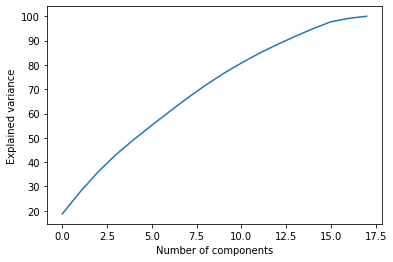

In [163]:
plt.plot(np.cumsum(pca_18.explained_variance_ratio_*100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

In [165]:
print('Variance explained by the 1st principal component = ', np.cumsum(pca_18.explained_variance_ratio_*100)[0])
print('Variance explained by the first 15 principal components = ', np.cumsum(pca_18.explained_variance_ratio_*100)[14])
print('Variance explained by the first 16 principal components = ', np.cumsum(pca_18.explained_variance_ratio_*100)[15])

Variance explained by the 1st principal component =  18.70248999433572
Variance explained by the first 15 principal components =  94.86489011717623
Variance explained by the first 16 principal components =  97.72462782872832


In [167]:
pca_95=PCA(n_components=0.95, random_state=1)
pca_95.fit(X_scaled)
X_pca_95 = pca_95.transform(X_scaled)
X_pca_95.shape

(5851, 16)

In [168]:
df_new = pd.DataFrame(X_pca_95, columns=['Perc of Subcontractors',
 'Country',
 'Director Is Recent',
 'Manager Is Recent',
 'Is Multi Discipline Project',
 'Is Front Loaded',
 'Is First Client Project',
 'Perc of Team Recent',
 'Project Duration Weeks',
 'Sector',
 'Perc of Stages with Hourly Rates',
 'Is Multi Team',
 'Team Size',
 'Project Size Sort Order',
 'Num Teams Involved',
 'Office'])

df_new['Profit Class']=df['Profit Class']
df_new.head()

,Perc of Subcontractors,Country,Director Is Recent,Manager Is Recent,Is Multi Discipline Project,Is Front Loaded,Is First Client Project,Perc of Team Recent,Project Duration Weeks,Sector,Perc of Stages with Hourly Rates,Is Multi Team,Team Size,Project Size Sort Order,Num Teams Involved,Office,Profit Class
0,2.893950,-0.198018,-1.827385,0.130885,1.417719,0.267626,1.064084,-0.866517,-0.380994,-1.935625,-1.134822,-1.519270,1.077437,0.895737,0.942632,-0.020052,1
1,-0.840665,2.720542,2.444526,3.185012,0.436839,-0.719683,0.097212,0.043750,-0.552842,-0.021777,0.594780,0.358515,-1.446845,0.202714,0.795064,3.748252,2
2,-2.260152,0.907746,0.208222,1.514566,0.856102,-1.552016,0.313654,-0.207799,0.352943,0.010192,0.003213,-0.494315,-0.236021,-0.472978,0.245084,-0.506587,2
3,-0.290690,2.195094,2.320906,2.889686,0.033680,-0.500766,-0.161398,0.038063,-0.344089,-0.539550,0.547072,0.495853,-1.504206,0.232080,1.069449,3.267947,1
4,0.755520,2.487971,2.382348,3.527436,-0.126429,-0.827925,-0.197133,0.224959,-0.232679,-0.077441,1.051588,0.122824,-2.003776,0.174193,1.744979,2.931031,0


In [169]:
X = df_new.drop(['Profit Class'], axis = 1).copy()

vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
1,1.0,Country
9,1.0,Sector
4,1.0,Is Multi Discipline Project
8,1.0,Project Duration Weeks
11,1.0,Is Multi Team
7,1.0,Perc of Team Recent
10,1.0,Perc of Stages with Hourly Rates
2,1.0,Director Is Recent
12,1.0,Team Size
13,1.0,Project Size Sort Order


In [170]:
len(df_new.columns), len(X.columns)

(17, 16)

In [175]:
# Save the final dataframes in CSV format
df_new.to_csv('csv-files/complete_redef.csv', index=False)